### Example 8 - Ore and Ice Arbitrage Backtest Results

In this example, we'll analyze the results from our three month backtest of our ore and ice
arbitrage strategy.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# We've collected results from our backtest into a CSV file with format:
#
# snapshot time, profit, gross, cost, type
#
# We'll start by reading this data into an array.
#
results_file = "results.csv"

opportunities = []
fin = open(results_file, 'r')
for line in fin:
    columns = line.strip().split(",")
    opportunities.append(dict(time=datetime.datetime.strptime(columns[0], "%Y-%m-%d %H:%M:%S"),
                             profit=float(columns[1]),
                             gross=float(columns[2]),
                             cost=float(columns[3]),
                             type=columns[4]))

In [3]:
# As before, we'll clean the opportunities list, collapsing adjacent opportunities into
# their first occurrence.  We'll use the same function as before:
def clean_opportunities(opps):
    new_opps = []
    stamp_map = {}
    types = set([x['type'] for x in opps])
    # Flatten opportunites for each type
    for next_type in types:
        stamp_list = []
        last = None
        for i in [x['time'] for x in opps if x['type'] == next_type]:
            if last is None:
                # First opportunity
                stamp_list.append(i)
            elif i - last > datetime.timedelta(minutes=5):
                # Start of new run
                stamp_list.append(i)
            last = i
        stamp_map[next_type] = stamp_list
    # Rebuild opportunities by only selecting opportunities in
    # the flattened lists.
    for opp in opps:
        type = opp['type']
        if opp['time'] in stamp_map[type]:
            new_opps.append(opp)
    # Return the new opportunity list
    return new_opps

opportunities = clean_opportunities(opportunities)

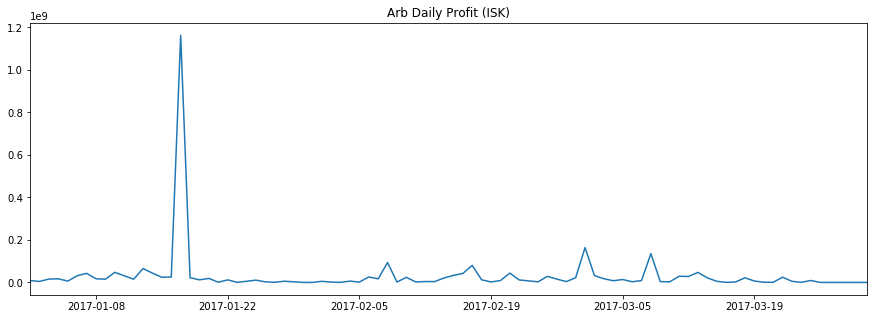

In [4]:
# Now let's convert the results into a DataFrame and take a look at the data
opps_df = DataFrame(opportunities, index=[x['time'] for x in opportunities])

# We can get daily statistics with some simple grouping
groups = opps_df.groupby(opps_df.index.date)

# Let's look at daily proft
profit_series = groups.profit.sum()
profit_series.plot(figsize=[15,5], title="Arb Daily Profit (ISK)")


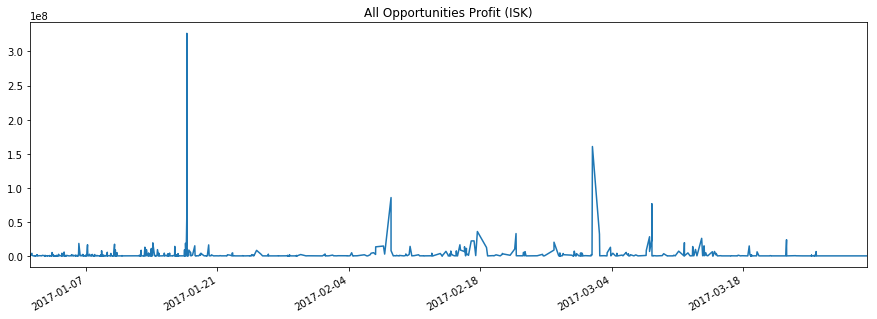

In [5]:
# There's a very clear outlier in our data.  The data for the outlier may be valid, but clearly
# does not represent common behavior and would skew our statistics around expected average performance.
# Therefore, we'll eliminate this outlier for our calculations.  Let's see if we can find this
# outlier in our source data.  We'll plot all profit to get an idea of reasonable scale.
opps_df.profit.plot(figsize=[15,5], title="All Opportunities Profit (ISK)")

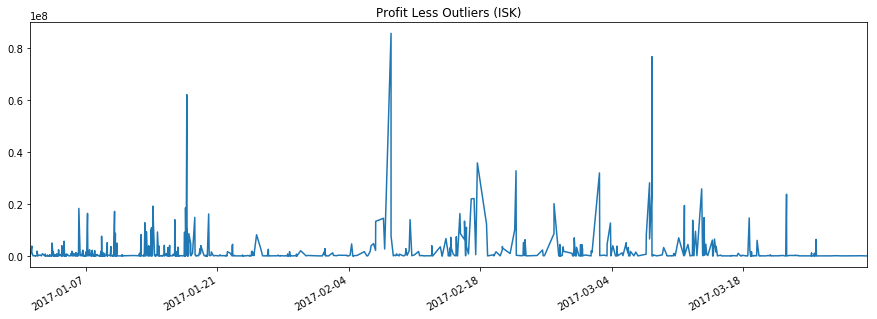

In [6]:
# In fact, it looks like there are two clear outliers.  Filtering above 150,000,000 ISK would seem to capture both:
opps_df[opps_df.profit < 150000000].profit.plot(figsize=[15,5], title="Profit Less Outliers (ISK)")

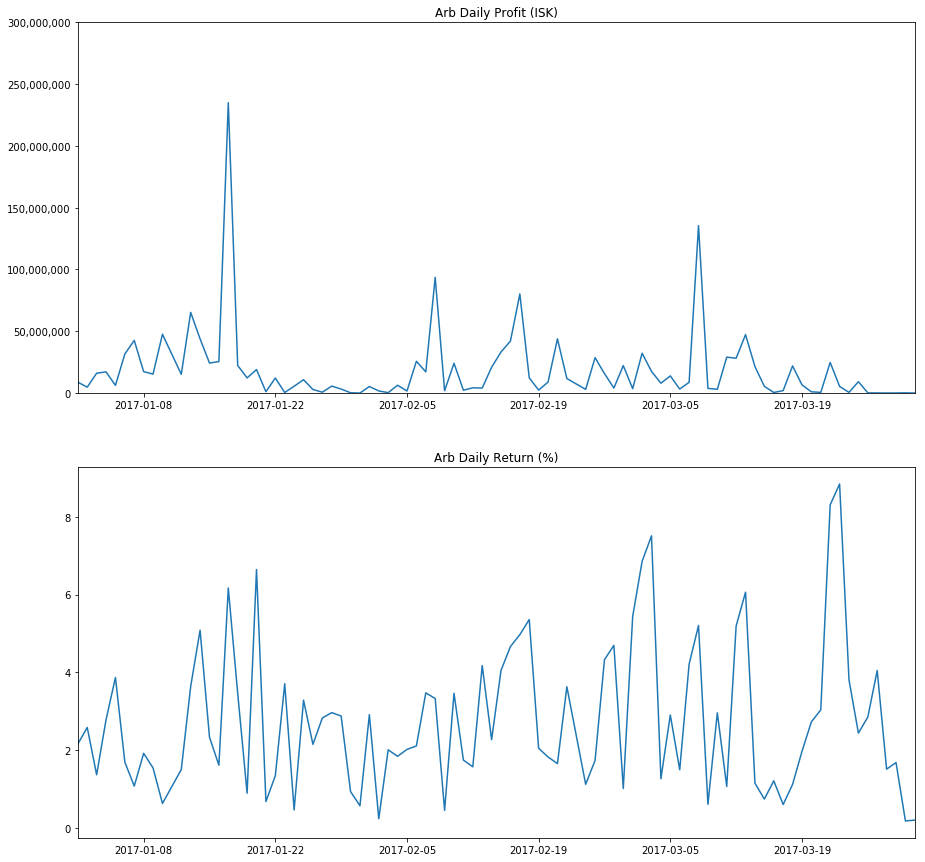

In [7]:
# We could filter even further, but we'll stop here as the remaining data seems to reasonably capture expected results.
# Now let's take a look at profit and return over time.
opps_filtered_df = opps_df[opps_df.profit < 150000000]
groups = opps_filtered_df.groupby(opps_filtered_df.index.date)
profit_series = groups.profit.sum()
return_series = groups.profit.sum() / groups.cost.sum() * 100

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
ax1.set_ylim([0, 300000000])
ax2 = fig.add_subplot(2,1,2)
profit_series.plot(ax=ax1, figsize=[15,15], title="Arb Daily Profit (ISK)")
return_series.plot(ax=ax2, figsize=[15,15], title="Arb Daily Return (%)")

In [8]:
# Steady results for profit are on the lower end while daily returns are consistently in the lower single
# digits.  We can formalize our intuition here by looking at a few aggregates.

# Average daily profit
print("Average daily profit: %s\n" % "{:,.2f}".format(profit_series.mean()))

# Average daily return
print("Average daily return: %s%%\n" % "{:,.2f}".format(return_series.mean()))

# Median daily profit
print("Median daily profit: %s\n" % "{:,.2f}".format(profit_series.quantile(0.5)))

# Median daily return
print("Median daily return: %s%%\n" % "{:,.2f}".format(return_series.quantile(0.5)))


Average daily profit: 18,900,775.99

Average daily return: 2.76%

Median daily profit: 8,837,417.04

Median daily return: 2.22%



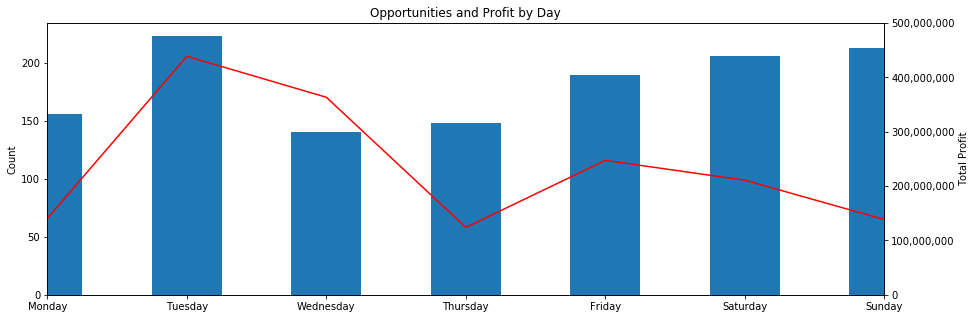

In [9]:
# These are modest numbers, certainly not good enough to exclude all other trading strategies.
# However, for the sake of completeness, we'll continue our analysis focusing on other 
# properties of this strategy.
#
# We know from experience that EVE is more active on the weekend.  Perhaps better opportunities 
# exist at those times.  We can group by day of the week to test that hypothesis.
#
by_dow = opps_filtered_df.groupby(opps_filtered_df.index.dayofweek)
by_dow_count = by_dow.profit.count().rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                                             4:'Friday',5:'Saturday',6:'Sunday'})
by_dow_sum = by_dow.profit.sum().rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                                         4:'Friday',5:'Saturday',6:'Sunday'})
#
# Now we can overlay opportunity count with total profit per day
#
ax1 = by_dow_count.plot(kind='bar', figsize=[15,5], title="Opportunities and Profit by Day")
ax1.set_ylabel("Count")
ax2 = by_dow_sum.plot(secondary_y=True, style='r')
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 500000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))

We can draw some interesting conclusions from these results:

1. Tuesday has a slight edge in terms of number of opportunities, but is the clear favorite in terms of profitability;
2. Despite having a large opportunity count, the weekends are not as profitable as we might expect; and, 
3. Sundays have surprisingly low profit given the number of opportunities.

We should be cautious not to read too much out of only three months worth of data.  Nonetheless, the results are interesting.

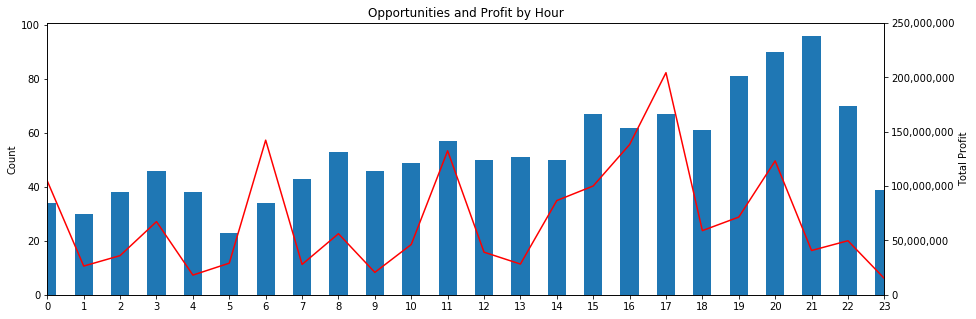

In [10]:
# Now let's consider whether certain times of day are more profitable.
# We can group by hour of the day to analyze this data.
#
by_hour = opps_filtered_df.groupby(opps_filtered_df.index.hour)
by_hour_count = by_hour.profit.count()
by_hour_sum = by_hour.profit.sum()
#
# Now we can overlay opportunity count with total profit per hour
#
ax1 = by_hour_count.plot(kind='bar', figsize=[15,5], title="Opportunities and Profit by Hour")
ax1.set_ylabel("Count")
ax2 = by_hour_sum.plot(secondary_y=True, style='r')
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 250000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))

From the data, the opportunity count shows a very natural progression from midnight \(UTC\) to a peak at 21:00.  However, profitable opportunities peak much earlier at 17:00 UTC.

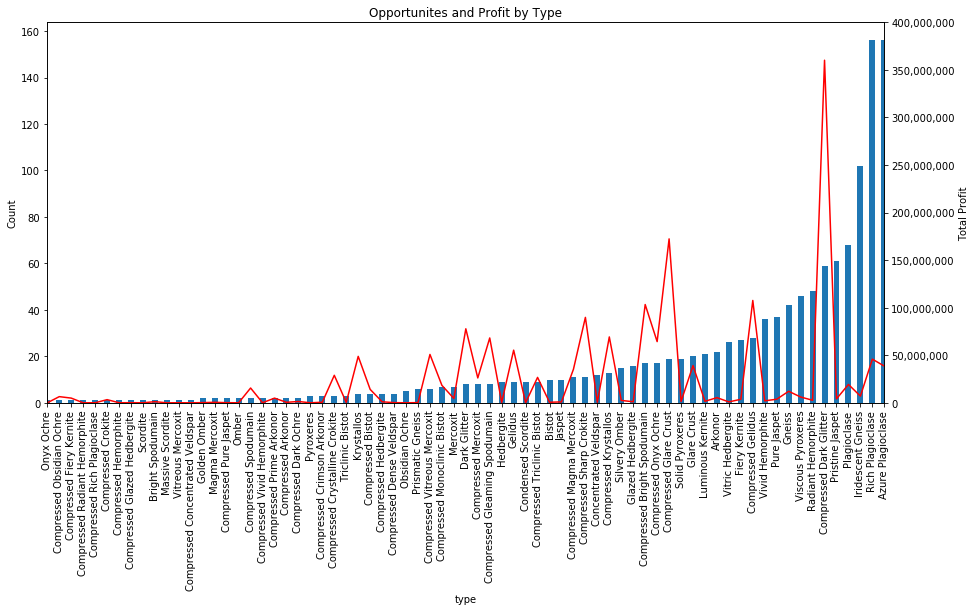

In [11]:
# Our final piece of analysis will consider whether some source materials are more profitable 
# (or present more opportunities) than others.  We can perform this analysis by grouping by type.
#
by_type = opps_filtered_df.groupby(opps_filtered_df.type)
by_type_count = by_type.profit.count()
by_type_sum = by_type.profit.sum()
#
# Now we can overlay opportunity count with total profit by type.
# For this example, it's useful to sort by count to allow variants
# of source material to be grouped together
#
ax1 = by_type_count.sort_values().plot(kind='bar', figsize=[15,7], sharex=True, title="Opportunites and Profit by Type")
ax1.set_ylabel("Count")
ax2 = by_type_sum.ix[by_type_count.sort_values().index].plot(secondary_y=True, style='r', rot=90, sharex=True)
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 400000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
ax2.get_xaxis().set_visible(False)

The plagioclase family of ores has a distinct grouping in terms of opportunity. That is perhaps not surprising given that this is a highly profitable high security ore in The Forge.  An analysis in Domain might show Kernite as a more dominant ore.

In terms of profitability, compressed dark glitter \(an ice\) is a clear outlier with a large number of opportunities as well.  This might be a focus for competitively priced bid orders to try to capture industrialists dumping excess stock on the market.

Our overall numbers for this strategy are somewhat disappointing.  At the median, we might expect to make 300M ISK per month.  However, the low risk of the strategy may make it worth adding to a larger collection of trading strategies.